In [1]:

import xarray as xr

store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})


In [2]:
target_lat = 62.1
target_lon = 9.25

In [3]:
tg_norway = ds['tg'].sel(
    latitude=target_lat, 
    longitude=target_lon, 
    method='nearest'
).sel(time=slice('2002-01-01', '2020-12-31'))
monthly_mean_full = tg_norway.resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [4]:
import xarray as xr

store = 'gs://leap-persistent-ro/data-library/feedstocks/metaflux_feedstock/meatflux_monthly.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})

In [5]:
gpp_2002_2020 = ds.sel(time=slice('2002-01-01', '2020-12-31'))
lat_norway = 62.15
lon_norway = 9.25
norway_gpp = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)
norway_reco = gpp_2002_2020.sel(
    latitude=lat_norway, 
    longitude=lon_norway, 
    method='nearest'
)['RECO']

norway_nee = norway_reco - norway_gpp.GPP
monthly_gpp_total = norway_gpp.GPP * norway_gpp.time.dt.days_in_month
monthly_reco_total = norway_reco * norway_reco.time.dt.days_in_month
monthly_nee_total = monthly_reco_total - monthly_gpp_total

In [6]:
import xarray as xr

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/MODIS_LAI/MODIS_LAI.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})

In [7]:
norway_lai = ds.sel(
    lat=lat_norway,
    lon=lon_norway, 
    method='nearest'
)
lai= norway_lai.sel(time=slice('2002-01-01', '2020-12-31'))
monthly_lai = lai['lai'].resample(time='1M').mean()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [8]:
import xarray as xr

store = 'gs://leap-persistent/data-library/GPCP-daily/GPCP-daily.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})

In [9]:
norway_precip = ds.sel(
    latitude=lat_norway,
    longitude=lon_norway, 
    method='nearest'
)

In [10]:
precip_2002_2020 = norway_precip.sel(time=slice('2002-01-01', '2020-12-31'))
monthly_precip = precip_2002_2020['precip'].resample(time='1M').sum()
daily_precip = precip_2002_2020.precip
daily_precip_loaded = daily_precip.load()
negative_count = (daily_precip_loaded < 0).sum().values
total_count = len(daily_precip_loaded)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [11]:
clean_daily_precip = daily_precip_loaded.where(daily_precip_loaded >= 0)
monthly_precip_clean = clean_daily_precip.resample(time='1M').sum()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [12]:
import pandas as pd

ml_data = pd.DataFrame({
    'time': monthly_precip_clean.time.values,
    'temperature': monthly_mean_full.values,
    'lai': monthly_lai.values,
    'precipitation': monthly_precip_clean.values,
    'nee': monthly_nee_total.values 
})

print(ml_data.head())
print(f"Shape: {ml_data.shape}")

        time  temperature       lai  precipitation        nee
0 2002-01-31    -5.661290  0.111640     106.822304 -12.389620
1 2002-02-28    -6.188571  0.005210     126.971954 -11.071642
2 2002-03-31    -4.732258  0.000000      95.268974 -12.328427
3 2002-04-30     1.192667  0.020144      37.684628 -11.272329
4 2002-05-31     5.573548  0.233350      68.357285 -11.693965
Shape: (228, 5)


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [14]:
X = ml_data[['temperature', 'lai', 'precipitation']]
y = ml_data['nee']

train_size_ratio = 0.8
train_size = int(len(ml_data) * train_size_ratio)

X_train_raw = X.iloc[:train_size]
y_train_raw = y.iloc[:train_size]
X_test_raw = X.iloc[train_size:]
y_test_raw = y.iloc[train_size:]


In [15]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()

sequence_length = 12

def create_sequences(X_data, y_data, seq_len):
   
    X_seq = []
    y_seq = []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data[i : i + seq_len])
        y_seq.append(y_data[i + seq_len]) # 预测序列的下一个值
    return np.array(X_seq), np.array(y_seq)

X_train_sequences, y_train_targets = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_sequences, y_test_targets = create_sequences(X_test_scaled, y_test_scaled, sequence_length)


X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_targets, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_targets, dtype=torch.float32)


In [16]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_sequences.shape[2] 
hidden_size = 64                       
num_layers = 2                         
output_size = 1                        

model = LSTMPredictor(input_size, hidden_size, num_layers, output_size)
print(model)


LSTMPredictor(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200 
batch_size = 24 
early_stopping_rounds = 20


In [18]:

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_losses = []
test_losses = []
min_test_loss = float('inf')
no_improve_epochs = 0

for epoch in range(num_epochs):
    model.train() 
    current_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()       
        optimizer.step()      
        current_train_loss += loss.item() * inputs.size(0)
    
    avg_train_loss = current_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval() 
    current_test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            current_test_loss += loss.item() * inputs.size(0)
    
    avg_test_loss = current_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


    if avg_test_loss < min_test_loss:
        min_test_loss = avg_test_loss
        no_improve_epochs = 0
        
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stopping_rounds:
            break

print("Break!")


Epoch [1/200], Train Loss: 1.0526, Test Loss: 0.8673
Epoch [10/200], Train Loss: 0.7774, Test Loss: 0.6497
Epoch [20/200], Train Loss: 0.5875, Test Loss: 0.5944
Epoch [30/200], Train Loss: 0.5199, Test Loss: 0.5312
Epoch [40/200], Train Loss: 0.5924, Test Loss: 0.7807
Epoch [50/200], Train Loss: 0.4408, Test Loss: 0.5090
Break!


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval() 


with torch.no_grad():
    
    y_pred_train_tensor = model(X_train_tensor.to(device))
    y_pred_train_scaled = y_pred_train_tensor.squeeze().cpu().numpy()
    
    y_pred_test_tensor = model(X_test_tensor.to(device))
    y_pred_test_scaled = y_pred_test_tensor.squeeze().cpu().numpy()

y_train_original = scaler_y.inverse_transform(y_train_targets.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_targets.reshape(-1, 1)).flatten()
y_pred_train_original = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test_original = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

print("train:")
print(f"MSE: {mean_squared_error(y_train_original, y_pred_train_original):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train_original, y_pred_train_original)):.4f}")
print(f"MAE: {mean_absolute_error(y_train_original, y_pred_train_original):.4f}")
print(f"R2: {r2_score(y_train_original, y_pred_train_original):.4f}")

print("\ntest:")
print(f"MSE: {mean_squared_error(y_test_original, y_pred_test_original):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)):.4f}")
print(f"MAE: {mean_absolute_error(y_test_original, y_pred_test_original):.4f}")
print(f"R2: {r2_score(y_test_original, y_pred_test_original):.4f}")


train:
MSE: 0.2606
RMSE: 0.5105
MAE: 0.3940
R2: 0.5983

test:
MSE: 0.3035
RMSE: 0.5509
MAE: 0.4585
R2: 0.4181


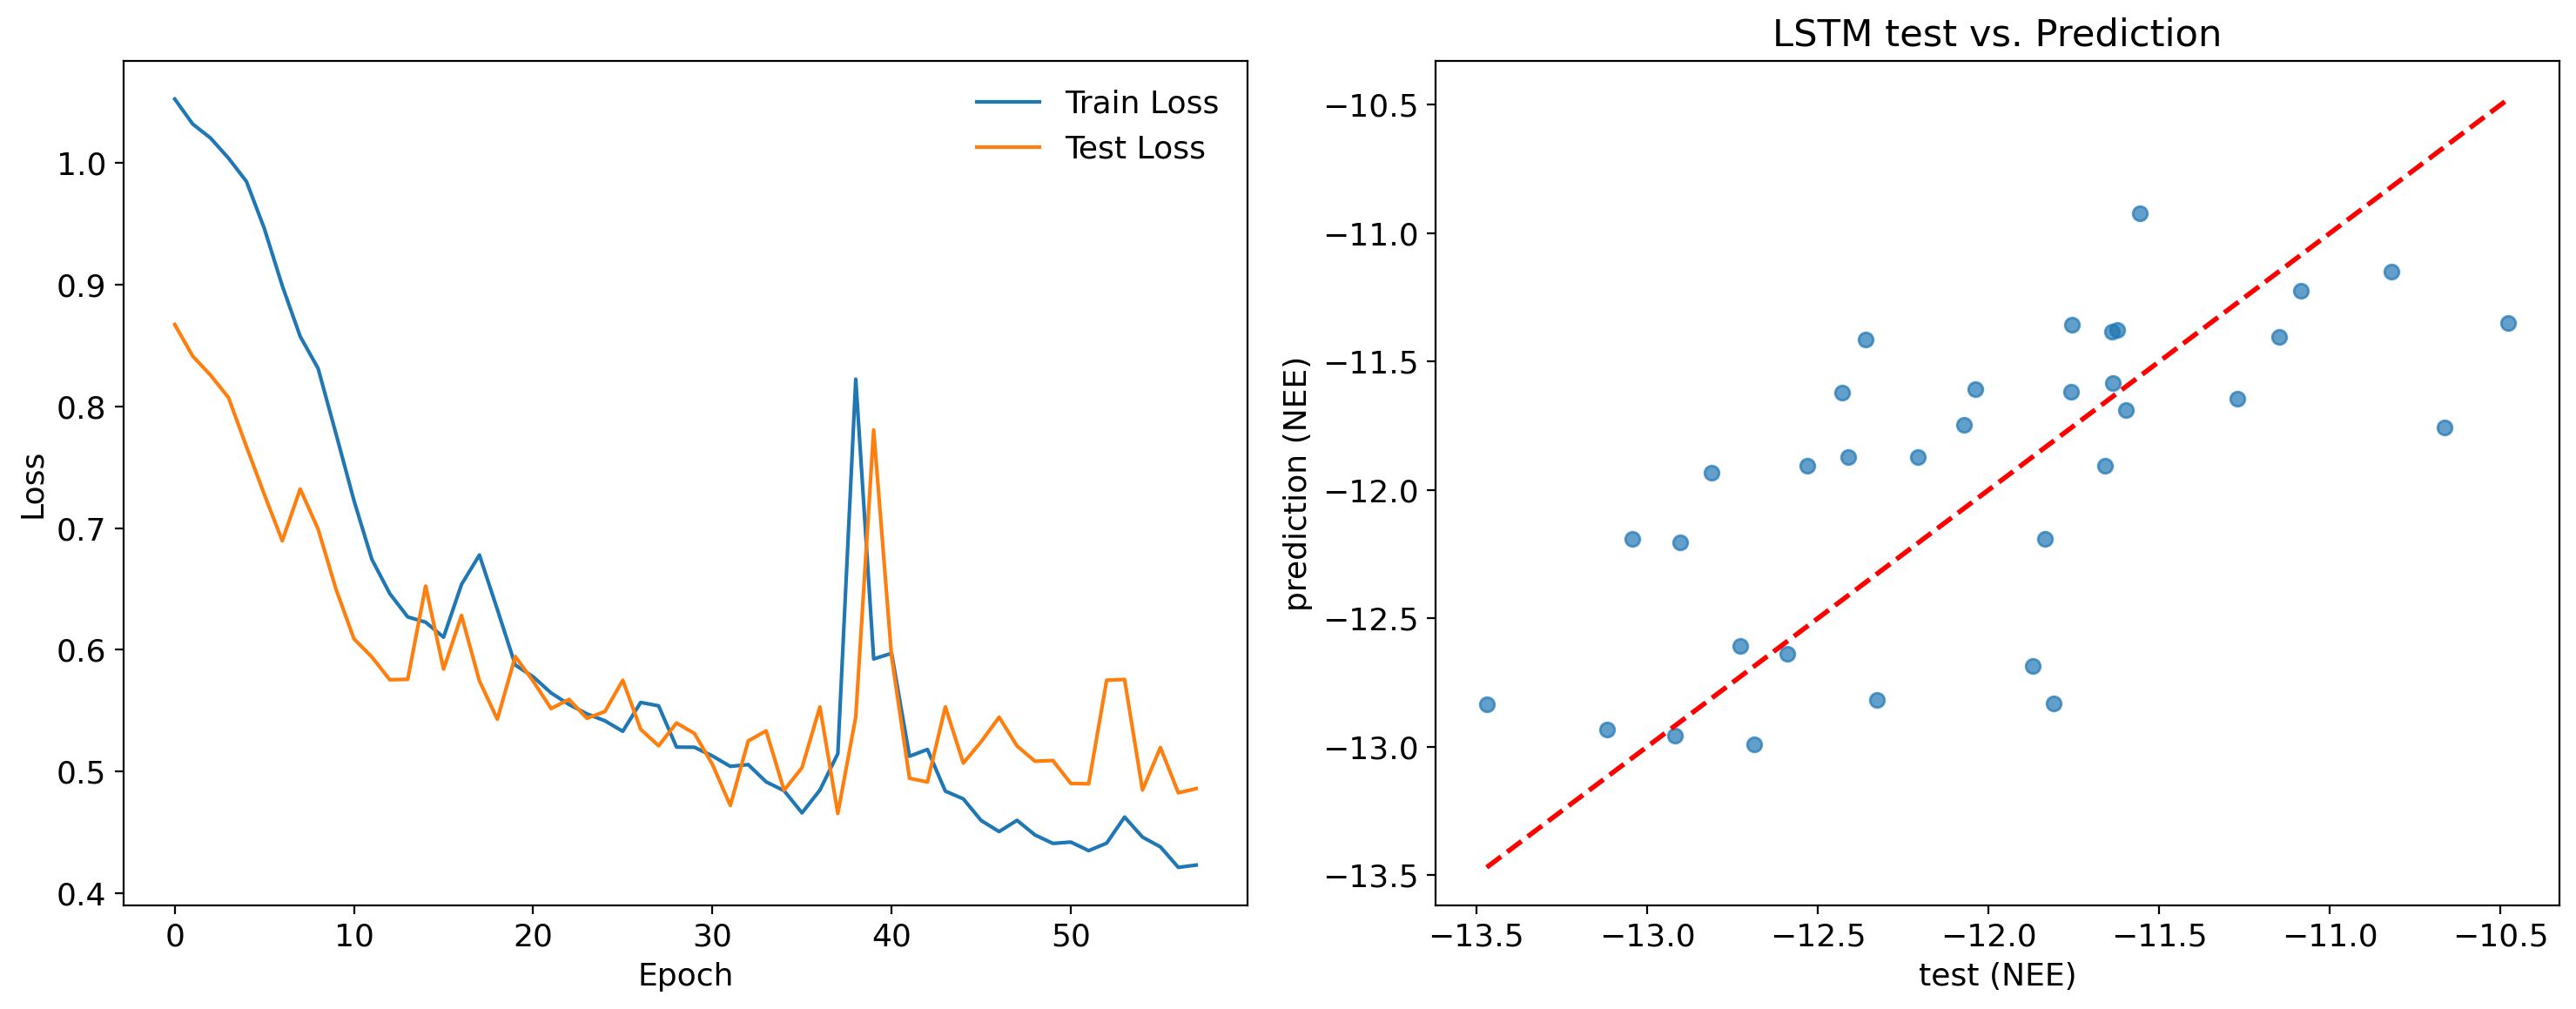

In [20]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
#plt.title('LSTM ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred_test_original, alpha=0.7)

plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.title('LSTM test vs. Prediction')
plt.xlabel('test (NEE)')
plt.ylabel('prediction (NEE)')
#plt.grid(True)

plt.tight_layout()
plt.show()
